In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def SDE_with_jump(x0 : float, t0 : float, T : float, dt : float,  mu : callable, sigma : callable, l : float, J : callable) -> tuple:
    """
    Solve the SDE with jump dx = mu(t, x) dt + sigma(t, x) dB + J(t, x) dN
    with x(t0) = x0, for t0 <= t <= T, with time step dt
    lambda is average number of jumps per unit time dt and J is the jump size
    """
    N = int((T-t0)/dt)
    X = np.zeros(N, dtype=float)
    jumps = []
    X[0] = x0
    for i in range(1, N):
        t = i*dt
        jump_happens = np.random.uniform(0, 1) < l * dt
        dN = J(t, X[i-1]) if jump_happens else 0
        X[i] = X[i-1] + mu(t, X[i-1]) * dt + sigma(t,  X[i-1]) * np.sqrt(dt) * np.random.randn() + dN
        jumps.append([t, dN]) if jump_happens else None
    return (X, jumps)

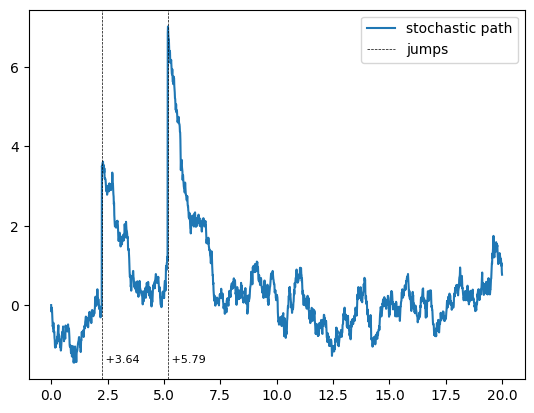

In [ ]:
np.random.seed(25) # Cherry picked realizations, jumps detection is not very robusts

# exponential drift and Ornstein-Uhlenbeck process with normal jumps
mu = lambda t, x : - x
sigma = lambda t, x : 1.0
J = lambda t, x : np.random.normal(0, 3)

X, jumps = SDE_with_jump(x0=0.0, t0=0.0, T=20.0, dt=0.01, mu=mu, sigma=sigma, l=0.2, J=J)
t = np.linspace(0, 20.0, len(X))

plt.plot(t, X)
for j in jumps:
    plt.axvline(x=j[0], color='k', linestyle='--', linewidth=0.5)
    plt.text(j[0], min(X), f' {j[1]:+.2f}', fontsize=8)
plt.legend(['stochastic path', 'jumps'])
plt.show()

We can extract the jumps using the variance as trashold. This procedure can be refined using some test of normality (like Shapiro-Wilk or Kolmogorov-Smirnov tests), we take the trashold based on the massimization of the normality of the price (whithout jumps, price should behave as brownian motion with gaussian distribution).

TODO: better detection of jumps and decay

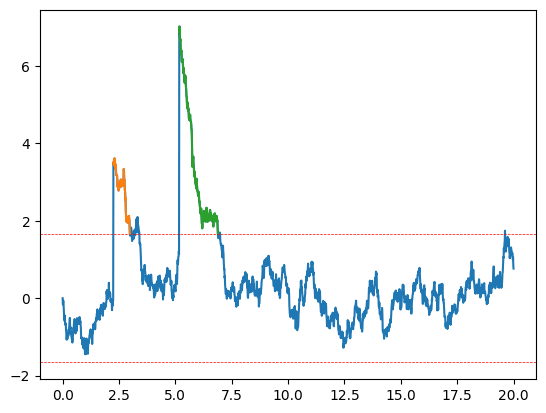

In [ ]:
# extract the jumps data (for now only data outside a sigma)
idx = np.where((X <= np.var(X)) & (X >= -np.var(X)))[0]
splited_x = np.split(X, idx)
splited_t = np.split(t, idx)
single_jumps = []
jump_time = []

plt.plot(t, X)
plt.axhline(y=np.var(X), color='r', linestyle='--', linewidth=0.5)
plt.axhline(y=-np.var(X), color='r', linestyle='--', linewidth=0.5)
for i in range(len(splited_x)):
    if len(splited_x[i]) > 20:  # (trashold) only plot jumps with more than 20 points data
        single_jumps.append(splited_x[i][1:])
        jump_time.append(splited_t[i][1:])
        plt.plot(splited_t[i][1:], splited_x[i][1:])
plt.show()

The price x(t) after the jumps behave accordingly to Ornstein-Uhlenbeck process. In this simple case $dx=-\theta x dt +dB$, so the deterministic solution is given by $x(t)=x_0e^{-\theta t}$. Using a fit we can get the parameter $\theta$, which give the **speed of reversion** or the half life of the price reversion dynamic.
From this, we could also find the time it takes for the asset to return to its mean price.

It coudld be nice if we distinguish between negative and positive price jumps: it could be that negative and positive shocks recover differently (assymmetry in mean reversion).

theta = 0.73
theta = 0.97


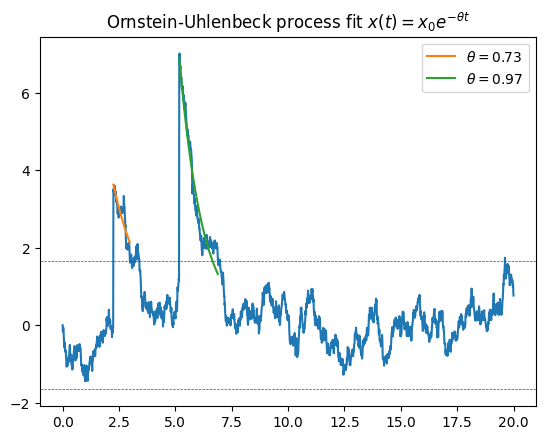

In [ ]:
def ou_func(t, x0, theta):
    return x0 * np.exp(-theta*t)

from scipy.optimize import curve_fit

# fit the jumps with Ornstein-Uhlenbeck process
plt.plot(t,X)
plt.axhline(y=np.var(X), color='r', linestyle='--', linewidth=0.5)
plt.axhline(y=-np.var(X), color='r', linestyle='--', linewidth=0.5)
plt.title('Ornstein-Uhlenbeck process fit $x(t)=x_0 e^{-\\theta t}$')
for i in range(len(single_jumps)):
    popt, pcov = curve_fit(ou_func, jump_time[i], single_jumps[i], p0=[0.0, 1.0])
    print(f"theta = {popt[1]:.2f}")
    #plt.plot(jump_time[i], single_jumps[i])
    plt.plot(jump_time[i], ou_func(jump_time[i], *popt), label=f'$\\theta = {popt[1]:.2f}$')
plt.legend()
plt.show()

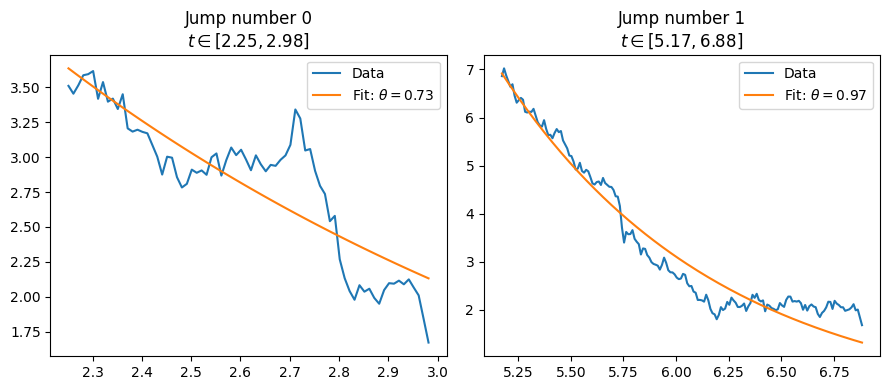

In [ ]:
fig, axs = plt.subplots(1, len(single_jumps), figsize=(4.5 * len(single_jumps), 4))

for i, ax in enumerate(axs):
    popt, pcov = curve_fit(ou_func, jump_time[i], single_jumps[i], p0=[0.0, 1.0])
    ax.plot(jump_time[i], single_jumps[i], label='Data')
    ax.plot(jump_time[i], ou_func(jump_time[i], *popt), label=f'Fit: $\\theta = {popt[1]:.2f}$')
    ax.set_title(f"Jump number {i}\n$t\\in[{jump_time[i][0]:.3}, {jump_time[i][-1]:.3}]$")
    ax.legend()

plt.tight_layout()
plt.show()

The number of jumps give an estimation for the $\lambda$ parameter of the stochastic jump driven by a poisson process. This quantity could give some indication about the stability of the asset.

In [ ]:
number_of_jumps = len(jump_time)
print(f"Number of jumps: {number_of_jumps}")
l_estimation = number_of_jumps / (t[-1] - t[0])
print(f"Estimated lambda: {l_estimation:.2f}")

Number of jumps: 2
Estimated lambda: 0.10


As mentioned before, without jumps the price of the asset should be a brownian process and it has to follow a normal distribution. We can use the trashold as before and compute a normality thest (here I've used Shapiro-Wilk) to ensure the brownian behaviour. After we can compute the 'cleaned' price variance to estimate $\sigma$ defined in the stochastic differential equation $dx=-\theta xdt+\sigma dB$. This quantity describe the volatility of the asset.

TODO: normality tests are not well suited (p-values are in fact very small), in this brownian process the tails are cut off because the gaussian distribution is valid only for $t\to\infty$

Shapiro-Wilk test
p-value of the cleaned data: 7.20e-10
p-value of the original data: 4.23e-44

Mean of the cleaned data: 0.04
Variance of the cleaned data: 0.35

Mean of the original data: 0.46
Variance of the original data: 1.66


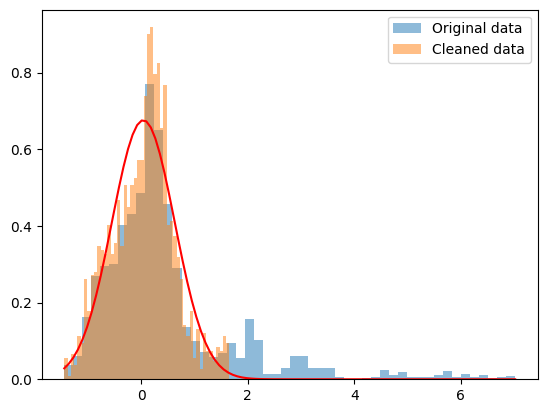

In [ ]:
# Remove jumps. Data schould be normal distributed, jumps are outliers
idx = np.where((X <= np.var(X)) & (X >= -np.var(X)))[0]
X_cleaned = X[idx]

from scipy.stats import shapiro, norm
_, p_cleaned = shapiro(X_cleaned)
_, p = shapiro(X)

print("Shapiro-Wilk test")
print(f"p-value of the cleaned data: {p_cleaned:.2e}")
print(f"p-value of the original data: {p:.2e}\n")

print(f"Mean of the cleaned data: {np.mean(X_cleaned):.2f}")
print(f"Variance of the cleaned data: {np.var(X_cleaned):.2f}\n")

print(f"Mean of the original data: {np.mean(X):.2f}")
print(f"Variance of the original data: {np.var(X):.2f}")

x_hist = np.linspace(min(X), max(X), 100)
y_hist = norm.pdf(x_hist, np.mean(X_cleaned), np.sqrt(np.var(X_cleaned)))
plt.hist(X, bins=50, alpha=0.5, density=True, label='Original data')
plt.hist(X_cleaned, bins=50, alpha=0.5, density=True, label='Cleaned data')
plt.plot(x_hist, y_hist, 'r')
plt.legend()
plt.show()

## Parameter estimation using FT
Using Fourier transform to find the mean reversion period.
TODO: test on real data and see if using maximum likelihood give better results.

In [ ]:
def SDE_solver(x0 : float, t0 : float, T : float, dt : float,  mu : callable, sigma : callable) -> np.array:
    """
    Solve the SDE dx = mu(t, x) dt + sigma(t, x) dB
    with x(t0) = x0, for t0 <= t <= T, with time step dt
    """
    N = int((T-t0)/dt)
    X = np.zeros(N, dtype=float)
    X[0] = x0
    for i in range(1, N):
        X[i] = X[i-1] + mu(i*dt, X[i-1]) * dt + sigma(i*dt,  X[i-1]) * np.sqrt(dt) * np.random.randn()
    return X

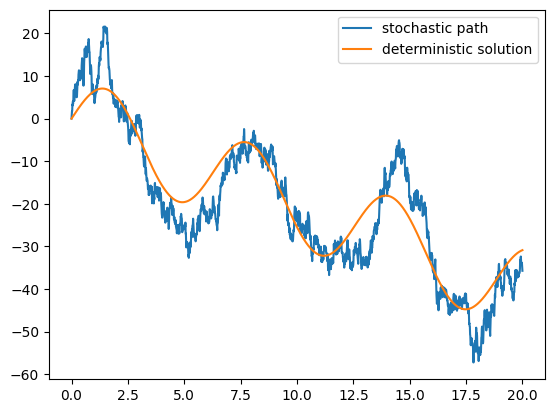

In [31]:
mu = lambda t, x : 10 * np.cos(t) + 10*np.sin(t)- 2*t-2-x
sigma = lambda t, x : 10.0

X = SDE_solver(x0=0.0, t0=0.0, T=20.0, dt=0.01, mu=mu, sigma=sigma)
t = np.linspace(0, 20.0, len(X))


plt.plot(t, X, label='stochastic path')
plt.plot(t, 10*np.sin(t)-2*t, label='deterministic solution')
plt.legend()
plt.show()

Linear fit slope: -2.2831486224095894
Expected slope: -2


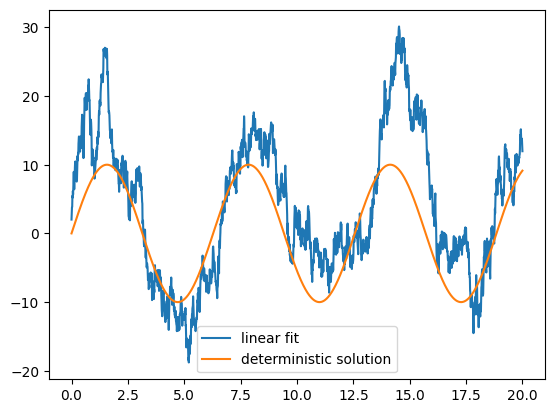

In [41]:
# Linearization of the solution
fit = np.polyfit(t, X, 1)
X_lin = X - fit[0]*t+fit[1]

slope = fit[0]
print("Linear fit slope:", slope)
print("Expected slope:", -2)
plt.plot(t, X_lin, label='linear fit')
plt.plot(t, 10*np.sin(t), label='deterministic solution')
plt.legend()
plt.show()

Max Frequency: 0.15 Hz
True Frequency: 0.1592 Hz


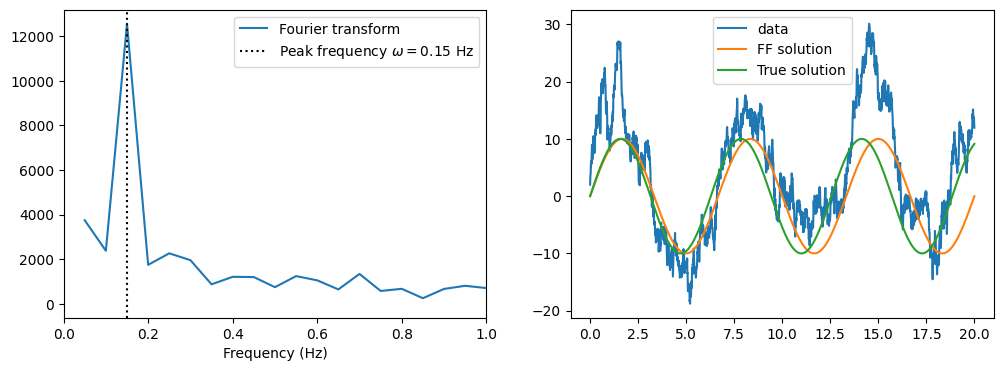

In [33]:
from scipy.fftpack import fft, fftfreq, ifft

fourier = np.abs(fft(X_lin))
freq = fftfreq(len(X_lin), 0.01)

mask = np.where(freq > 0)
freq = freq[mask]
peak = freq[np.argmax(fourier[mask])]

fourier[fourier < 50] = 0
inverse = np.abs(ifft(fourier))

print(f"Max Frequency: {peak:.4} Hz")
print(f"True Frequency: {(1/(np.pi*2)):.4} Hz")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(freq, fourier[mask], label='Fourier transform')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_xlim(0, 1)
ax1.axvline(peak, linestyle=':', color='k', label=f'Peak frequency $\\omega=${peak:.4} Hz')
ax1.legend()
ax2.plot(t, X_lin, label='data')
ax2.plot(t, 10*np.sin((2*np.pi*peak)*t), label='FF solution')
ax2.plot(t, 10*np.sin(t), label='True solution')
ax2.legend()
plt.show()

## Maximum Likelihood Estimation
As probability, we aproximate the propagator with a gaussian (we should solve the Fokker-Planck equation)

$$dx(t)=f(x,t,\boldsymbol{\theta})dt+g(x,t,\boldsymbol{\theta})dB(t)$$

$$p_{\boldsymbol{\theta}}(x,t|y)\simeq\mathcal{N}_y(x+f(x,t,\boldsymbol{\theta})t, tg^2(x,t,\boldsymbol{\theta}))$$

$$\mathcal{L}(x,t,\boldsymbol{\theta})=\prod p_{\boldsymbol{\theta}}(x,t|y)$$

$$\boldsymbol{\theta}=\arg\max_{\boldsymbol{\theta}}\mathcal{L}(x,t,\boldsymbol{\theta})$$

In [40]:
# Simple example with few parameters tailored for this example
# It can be generalized for different models

def propagator(x : float, y : float, t : float, f :callable, g : callable, thata : list)  -> float:
    return np.exp(-(y-x-f(t,x,thata)*t)**2/(2*t*g(x,thata)**2))/np.sqrt(2*np.pi*t*g(x,thata)**2)

def log_likelihood(theta, X, t, f, g):
    N = len(X)
    logL = 0
    for i in range(1, N):
        logL += np.log(propagator(X[i-1], X[i], t[i]-t[i-1], f, g, theta))
    return -logL

def f(t, x, theta):
    return theta[0]*np.cos(t*theta[1]) + theta[0]*np.sin(t*theta[1]) + theta[2]*t + theta[2] - x

def g(x, theta):
    return theta[3]


from scipy.optimize import minimize
params = [max(X_lin)/2, 2*np.pi*peak, slope, 10]
print("Initial guess:",params)
res = minimize(log_likelihood, params, args=(X_lin, t, f, g), method='Powell')
print("Optimization results:", res.get('x'))

Initial guess: [15.056495564550053, 0.942477796076938, -2.2831486224095894, 10]
Optimization results: [ 6.76291764  0.94252805 -2.28314862 10.27694396]


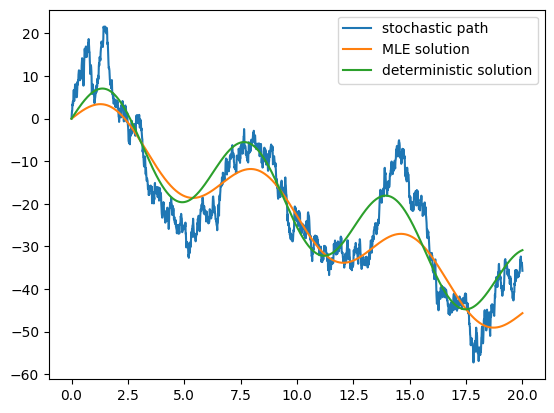

In [39]:
plt.plot(t, X, label='stochastic path')
plt.plot(t, res.get('x')[0]*np.sin(t*res.get('x')[1])+res.get('x')[2]*t, label='MLE solution')
plt.plot(t, 10*np.sin(t)-2*t, label='deterministic solution')
plt.legend()
plt.show()